In [3]:
# import all the relevant libraries
import wfdb
import mne
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, hamming_loss
from sklearn.pipeline import make_pipeline,Pipeline
from sklearn.preprocessing import FunctionTransformer,StandardScaler
from mne.datasets import sample
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, KFold
from mne_features.feature_extraction import extract_features
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectKBest,f_classif

C:\Users\piotr\anaconda_projects\anaconda3\Lib\site-packages\mne_features\mock_numba.py:12: UserWarning: Numba needs NumPy 2.0 or less. Got NumPy 2.2.. Your code will be slower.
  warn('{}. Your code will be slower.'.format(err))


In [4]:
# This function takes in the record path of a PSG file and outputs the raw annotated data. It renames, changes types and removes channels so that they
# are consistent between different patients. Some patients had more/less data collected through different manners which had to be fixed.
def raw_data_compiler(record_path):
    record = wfdb.rdrecord(record_path)
    annotation = wfdb.rdann(record_path, 'st')
    
    annotation_mne = mne.Annotations(
        onset=annotation.sample / record.fs,
        duration=30,
        description=annotation.aux_note
    )
    
    signals = record.p_signal  # Signal data as NumPy array
    sampling_rate = record.fs  # Sampling frequency (e.g., 250 Hz)
    channel_names = record.sig_name  # Channel names
    seen_categories = set()
    
    # Assign types while ensuring only the first occurrence is assigned correctly
    channel_types = []
    channel_names_updated = []
    
    for ch in channel_names:
        if "EEG" in ch and "EEG" not in seen_categories:
            channel_types.append("eeg")
            channel_names_updated.append("EEG")
            seen_categories.add("EEG")
        elif "Resp" in ch and "Resp" not in seen_categories:
            channel_types.append("resp")
            channel_names_updated.append("Respiratory")
            seen_categories.add("Resp")
        elif "ECG" in ch and "ECG" not in seen_categories:
            channel_types.append("ecg")
            channel_names_updated.append("ECG")
            seen_categories.add("ECG")
        else:
            channel_types.append("misc")
            channel_names_updated.append(ch)
    # Create MNE Info object
    info = mne.create_info(
        ch_names=channel_names_updated,
        sfreq=sampling_rate,
        ch_types=channel_types
    )
    # Convert signals to MNE RawArray
    raw = mne.io.RawArray(signals.T, info)
    
    # Add annotations to the raw object
    raw.set_annotations(annotation_mne)
    misc_channels = [ch for ch, ch_type in zip(channel_names_updated, channel_types) if "misc" in ch_type]
    raw.drop_channels(misc_channels)
    
    return raw

In [7]:
# compile a list of raw data for each subject and combine it into a single large raw file.
List_of_subjects=open(r"\Users\piotr\Desktop\PSG data\List of subjects.txt","r").read().split("\n")
list_of_raw_data=[]
for i in List_of_subjects:
    record_path = fr"C:\Users\piotr\Desktop\PSG data\MIT Data\{i}"
    list_of_raw_data.append(raw_data_compiler(record_path))
raw=mne.concatenate_raws(list_of_raw_data)

Creating RawArray with float64 data, n_channels=4, n_times=1800000
    Range : 0 ... 1799999 =      0.000 ...  7199.996 secs
Ready.
Creating RawArray with float64 data, n_channels=4, n_times=2700000
    Range : 0 ... 2699999 =      0.000 ... 10799.996 secs
Ready.
Creating RawArray with float64 data, n_channels=4, n_times=2700000
    Range : 0 ... 2699999 =      0.000 ... 10799.996 secs
Ready.
Creating RawArray with float64 data, n_channels=4, n_times=2025000
    Range : 0 ... 2024999 =      0.000 ...  8099.996 secs
Ready.
Creating RawArray with float64 data, n_channels=4, n_times=5400000
    Range : 0 ... 5399999 =      0.000 ... 21599.996 secs
Ready.
Creating RawArray with float64 data, n_channels=4, n_times=5400000
    Range : 0 ... 5399999 =      0.000 ... 21599.996 secs
Ready.
Creating RawArray with float64 data, n_channels=4, n_times=5400000
    Range : 0 ... 5399999 =      0.000 ... 21599.996 secs
Ready.
Creating RawArray with float64 data, n_channels=4, n_times=5400000
    Range

In [8]:
# Reclassify events. The original annotations had descriptions that were not relevant to this classifier. Everything is relabled either
event_labels = {
    1: "Hypopnea",
    2: "Obstructive Apnea",
    3: "Central Apnea",
    4: "No Apnea Event"
}
new_id = {}
for desc in raw.annotations.description:
    if "H" in desc or "HA" in desc:  # Hypopnea
        new_id[desc] = 1
    elif " A" in desc or "X" in desc:  # Obstructive Apnea
        new_id[desc] = 2
    elif "CA" in desc or "CAA" in desc:  # Central Apnea
        new_id[desc] = 3
    else:  # Other
        new_id[desc] = 4

# Generate events with the new mapping
events, event_id = mne.events_from_annotations(raw, event_id=new_id)

new_annotations = mne.Annotations(
    onset=events[:, 0] / raw.info["sfreq"],  # Convert sample index to seconds
    duration=[30] * len(events),  # Assume each event lasts 30 seconds
    description=[event_labels[e] for e in events[:, 2]]  # Convert IDs back to labels
)

Used Annotations descriptions: [np.str_('1'), np.str_('1 A'), np.str_('1 A X'), np.str_('1 CA'), np.str_('1 CAA'), np.str_('1 CAA CAA'), np.str_('1 CAA CAA L'), np.str_('1 CAA HA'), np.str_('1 CAA X'), np.str_('1 H'), np.str_('1 H H'), np.str_('1 H HA'), np.str_('1 H X'), np.str_('1 HA'), np.str_('1 HA CA'), np.str_('1 HA CAA'), np.str_('1 HA H'), np.str_('1 HA HA'), np.str_('1 HA L'), np.str_('1 HA X'), np.str_('1 L'), np.str_('1 L L'), np.str_('1 LA'), np.str_('1 LA LA'), np.str_('1 LA X'), np.str_('1 OA'), np.str_('1 OA OA'), np.str_('1 OA X'), np.str_('1 X'), np.str_('1 X H'), np.str_('1 X L'), np.str_('1 X X'), np.str_('2'), np.str_('2 A'), np.str_('2 A A A'), np.str_('2 CA'), np.str_('2 CAA'), np.str_('2 H'), np.str_('2 H H'), np.str_('2 H HA'), np.str_('2 H L'), np.str_('2 H LA'), np.str_('2 HA'), np.str_('2 HA H'), np.str_('2 HA HA'), np.str_('2 HA L'), np.str_('2 HA X'), np.str_('2 L'), np.str_('2 L A'), np.str_('2 L H'), np.str_('2 L HA'), np.str_('2 L L'), np.str_('2 L LA'),

In [9]:
# Set the new annotations in copies of raw and split the data into train and test. About 80/20 split. Also extracting events, to know when what happend.
raw_copy1=raw.copy().set_annotations(new_annotations)
raw_copy2=raw.copy().set_annotations(new_annotations)
raw_train,raw_test=raw_copy1.crop(tmin=0,tmax=245000),raw_copy2.crop(tmin=245001)
events_train, event_id_train = mne.events_from_annotations(raw_train)
events_test, event_id_test = mne.events_from_annotations(raw_test)
print(raw_train.times[-1]/(raw_train.times[-1]+raw_test.times[-1]))

Used Annotations descriptions: [np.str_('Central Apnea'), np.str_('Hypopnea'), np.str_('No Apnea Event'), np.str_('Obstructive Apnea')]
Used Annotations descriptions: [np.str_('Central Apnea'), np.str_('Hypopnea'), np.str_('No Apnea Event'), np.str_('Obstructive Apnea')]
0.7948893584741935


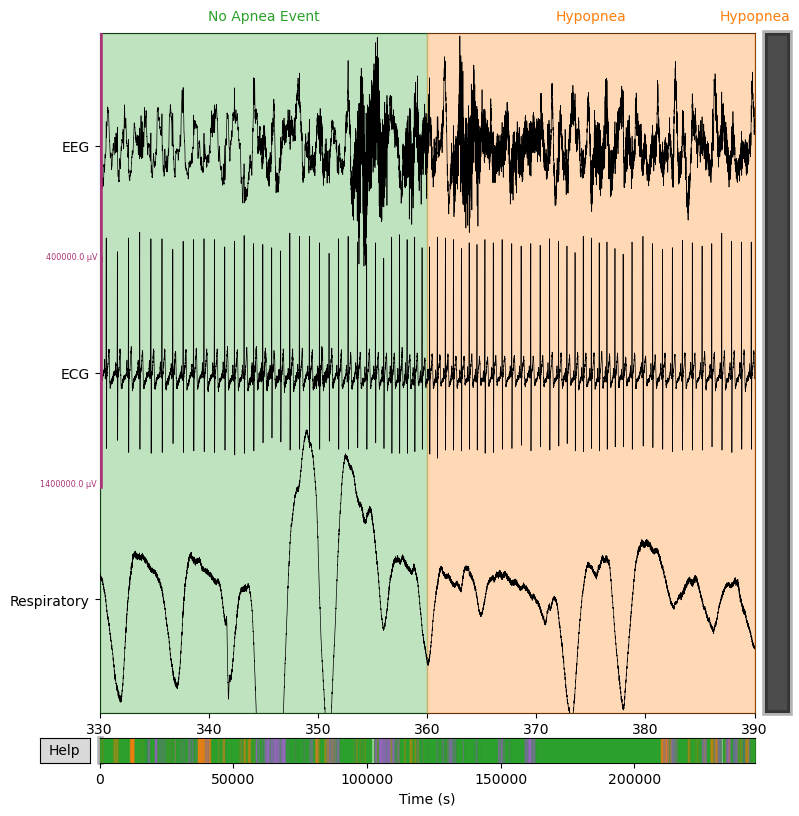

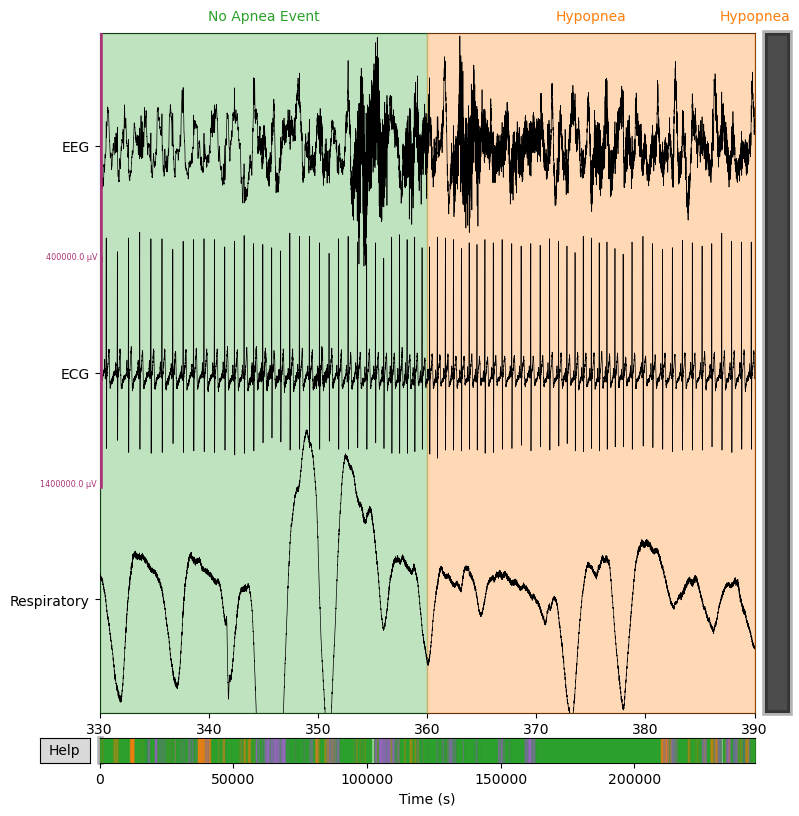

In [71]:
# plotting an event jsut to make sure annotations are correct.
raw_train.plot(start=330,duration=60,color="k",
            picks=["ECG",'Respiratory',"EEG"],
            scalings=dict(eeg=0.2,  ecg=0.7, resp=1))

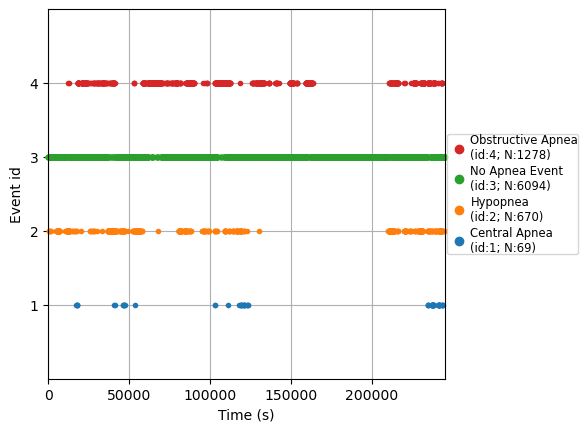

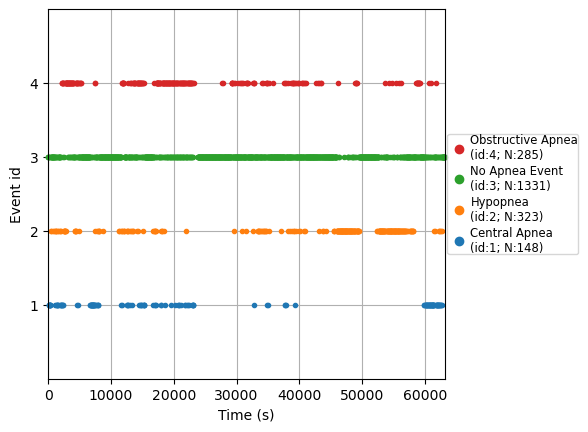

In [10]:
# Plotting the types of events happening at each time.
fig = mne.viz.plot_events(
    events_train,
    event_id=event_id_train,
    sfreq=raw_train.info["sfreq"],  # Sampling frequency of the raw data
    first_samp=raw_train.first_samp,  # First sample index of the raw data
)

# Extract color cycle for event colors
stage_colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

plt.show()
import matplotlib.pyplot as plt
# Plot the events
fig = mne.viz.plot_events(
    events_test,
    event_id=event_id_test,
    sfreq=raw_test.info["sfreq"],  # Sampling frequency of the raw data
    first_samp=raw_test.first_samp,  # First sample index of the raw data
)

# Extract color cycle for event colors
stage_colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

plt.show()

In [11]:
# creating epochs (windowed data essentially) for the events previously extracted.
tmax = 30.0 - 1.0 / raw.info["sfreq"]  # tmax in included
epochs_train = mne.Epochs(
    raw_train,
    events=events_train,
    tmin=0.0,
    tmax=tmax,
    baseline=None,
    picks=["ECG",'Respiratory',"EEG"]
)
epochs_test=mne.Epochs(
    raw_test,
    events=events_test,
    tmin=0.0,
    tmax=tmax,
    baseline=None,
    event_repeated="merge",
    picks=["ECG",'Respiratory',"EEG"]
)

Not setting metadata
8111 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
2087 matching events found
No baseline correction applied
0 projection items activated


In [21]:
# We now extract the features from each epoch, we extract many features and we will reduce dimensions later.
# We use the mne_features package to save us some trouble. Since the data has three channels each epoch consists of 3 times series
data_train = epochs_train.get_data()
data_test =epochs_test.get_data()
selected_funcs = {'mean', 'ptp_amp', 'std',"variance","skewness","kurtosis","rms","pow_freq_bands"}
y_train = epochs_train.events[:, 2]
y_test = epochs_test.events[:, 2]
X_train = extract_features(data_train, raw_train.info['sfreq'], selected_funcs)
X_test = extract_features(data_test, raw_test.info['sfreq'], selected_funcs)

Using data from preloaded Raw for 8111 events and 7500 original time points ...
1 bad epochs dropped
Using data from preloaded Raw for 2087 events and 7500 original time points ...
0 bad epochs dropped


In [40]:
# we now have all the data ready so we creaated a pipline, we scale the data, select features and learn.
pipe = Pipeline([('scaling', StandardScaler()),("selection", SelectKBest(f_classif, k=10)),
                 ('learning', GradientBoostingClassifier(n_estimators=100, random_state=41))])

In [27]:
# we now train the model and test it.
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
acc = accuracy_score(y_test, y_pred)

In [35]:
X=

0.6372783900335409


In [31]:
raw.set_annotations(new_annotations)
events=events, event_id = mne.events_from_annotations(raw)
epochs=mne.Epochs(
    raw,
    events=events,
    tmin=0.0,
    tmax=tmax,
    baseline=None,
    event_repeated="merge",
    picks=["ECG",'Respiratory',"EEG"]
)

Used Annotations descriptions: [np.str_('Central Apnea'), np.str_('Hypopnea'), np.str_('No Apnea Event'), np.str_('Obstructive Apnea')]
Not setting metadata
10197 matching events found
No baseline correction applied
0 projection items activated


In [39]:
selected_funcs = {'mean', 'ptp_amp', 'std',"variance","skewness","kurtosis","rms","pow_freq_bands"}
data=epochs.get_data()
y_data = epochs.events[:, 2]
X_data = extract_features(data, raw_train.info['sfreq'], selected_funcs)

Using data from preloaded Raw for 10197 events and 7500 original time points ...
0 bad epochs dropped


In [43]:
cross_val_score(pipe,X_data,y_data)

array([0.53137255, 0.45196078, 0.61353605, 0.54340363, 0.14958313])